In [1]:
# Libraries:
library(tidyverse)
library(readr)
library(dplyr)
library(ggplot2)
library(glmnet)
library(broom)
library(tidymodels)
library(repr)
library(mltools)
library(caret)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.0     ✔ rsample      1.2.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ recipes      1.0.8     ✔ yardstick    1

## 2) Methods: Plan

To approach our question, we will conduct **logistic regression** as our response is a binary variable. This will be fit for a **predictive model**. However, there are a few key steps we need to take before conducting any tests. 

As seen from the EDA and Correlation Heatmap above, we have a wide selection of predictors to select from. We intend to use these predictors in order to explain our overarching question about employee retention, but a challenging obstacle is presented beforehand: how can we improve our prediction accuracy, and what can we do in order to increase model interpretibility? There may be variables that aren't relevant to our analysis, and including them would only increase variance. Let us constrain our project to only variables that are deemed relevant to our topic. To do so, we will split our dataset and perform **LASSO Regularization** to shrink our model before performing regression. This is our **Feature Selection**, and will be shown below. Afterwards, we will test our model and further discuss the findings.



## Feature Selection:

Throughout this section, we will be discussing how and why we chose our covariates. The goal for our LASSO regularization is to find the optimum number of predictors that produces the highest average AUC. In doing so, the lasso method is able to reduce the number of predictors we will use in our model by shrinking their coefficients to zero during optimization, which will help improve our models interpretibility. Furthermore, this will hopefully coincide with our correlation heatmap from above and we will approach this in our discussion. 

Cross-fold validation can be used initially to select the number of parameters as it reduces the risk of overfitting, tunes the parameters and selects the ones that generalizes well to new data, and reduces variability.

Now we will split our data into training and testing, and prepare the training data for LASSO. We will do this at a 60/40 ratio for predictive purposes. Note that we are dropping `Gender` and `JoiningYear` as per the reasons in the intro.

In [2]:
# Main Developer: Andy Hong

set.seed(1234)

## load data
employee  <- read.csv("Employee.csv")

## split into training and testing
split <- initial_split(employee, prop = 0.6) 

employee_training <- training(split) %>%
    select(-Gender, -JoiningYear)
employee_testing <- testing(split) %>%
    select(-Gender, -JoiningYear)

LASSO uses the `glmnet` function which only works on model matrixes, so we will use `model.matrix` to prepare our data. We will also remove the (Intercept) column, which is filled with ones and not relevant to our preparation.


In [3]:
# Main Developer: Andy Hong

set.seed(1234)

model_matrix_X_train <- 
    model.matrix(LeaveOrNot ~ ., employee_training)[,-1]

matrix_Y_train <- 
    as.matrix(employee_training$LeaveOrNot, ncol = 1)

With our prepared training data, we can use `cv.glmnet` to find the optimal $\lambda$ value that provides the largest average AUC. 

We will use 5-fold cross validation for this model.

In [4]:
# Main Developer: Andy Hong

set.seed(1234)

employee_cv_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  type.measure = 'auc',
  nfolds = 5)

employee_cv_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.00371    37  0.6959 0.008299       7
1se 0.01364    23  0.6876 0.006949       6

To help interpreset the data above, lets first graph this using the plot() function


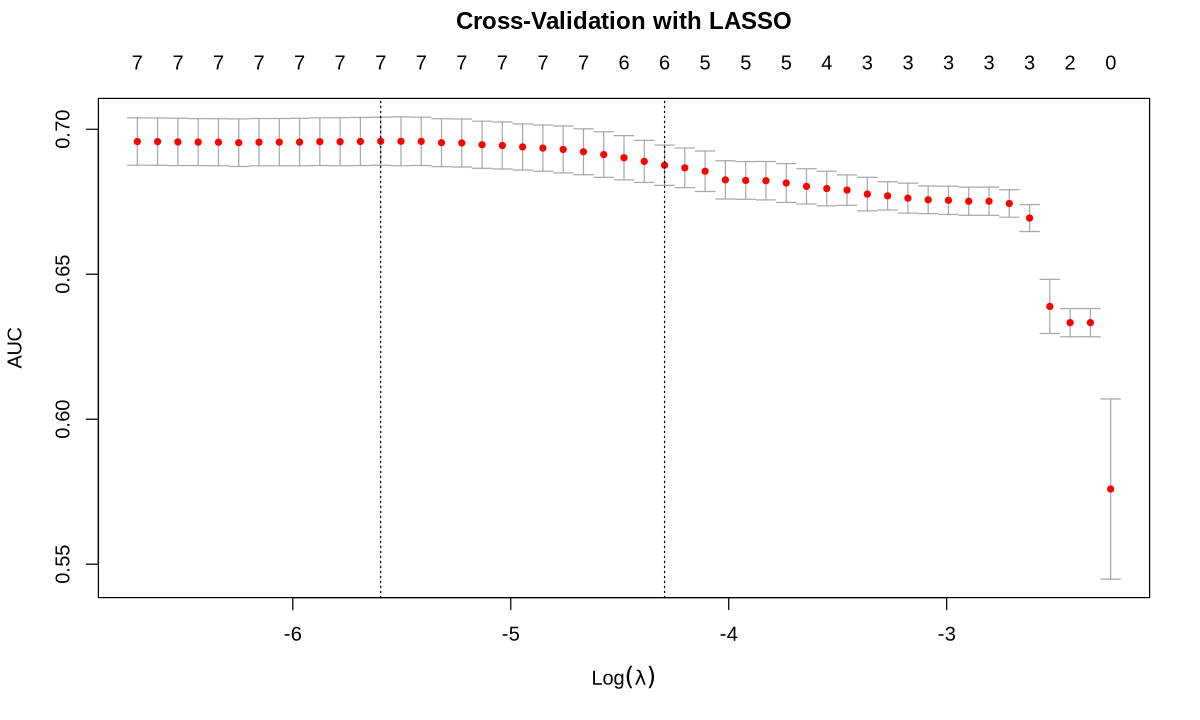

In [5]:
# Main Developer: Andy Hong

set.seed(1234)

options(repr.plot.width = 10, repr.plot.height = 6)

plot(employee_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

The two vertical liness from `cv.glmnet()` correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$.


- $\hat{\lambda}_{\text{1SE}}$ is the highest $\lambda$ for which the model has an average AUC within one standard error of the maximum.

The numbers across the top of the graph indicate the number of predictors (value of $\lambda$) used. For our case, we will use $\hat{\lambda}_{\text{1SE}}$, as our goal is to improve model interpretibility and the most important set of predictors is more useful for feature selection.

We will extract this value of $\lambda$.

In [6]:
# Main Developer: Andy Hong

set.seed(1234)

employee_cv_lambda1se_LASSO_value <- round(employee_cv_lambda_LASSO$lambda.1se, 4)
employee_cv_lambda1se_LASSO_value

[1] 0.0136

Now we can use this value for LASSO to determine which predictors to select using `glmnet`.

In [7]:
# Main Developer: Andy Hong

set.seed(1234)

employee_LASSO <- glmnet(
x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  lambda = employee_cv_lambda1se_LASSO_value
)

coef(employee_LASSO)


9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)                0.67284687
EducationMasters           0.63264212
EducationPHD               .         
CityNew Delhi             -0.03687988
CityPune                   0.72083728
PaymentTier               -0.50340855
Age                       -0.01095366
EverBenchedYes             0.30887762
ExperienceInCurrentDomain  .         

Interesting! We are given `EducationMasters`, `CityNew Delhi`, `CityPune`, `PaymentTier`, `Age`,  and `EverBenchedYes` as our parameters. It seems that LASSO chose subsets of our variables (`EverBenchedYes` rather than just `EverBenched`) for our predictors. 

For simplicity and once again, model interpretability, we will use the base predictors `Education`, `PaymentTier`, `City`, `Age`, and `EverBenched`. 


## Testing the Model

Our last step is to test our model. To do this, we will create our **logistic model** based off the covariates found above fit off the training data. Then, we will use the trained model to predict the testing data, and we will display this using a confusion matrix.

In [8]:
# Main Developer: Andy Hong

set.seed(1234)

employee_logistic_model <- glm(LeaveOrNot ~ Education + City + PaymentTier + Age + EverBenched, 
                               data = employee_training, family = 'binomial')

employee_pred_class <- round(predict(employee_logistic_model, newdata = employee_testing, type = 'response'))

employee_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(employee_pred_class),
    reference = as.factor(employee_testing$LeaveOrNot),
    positive = '1'
)
employee_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1063  416
         1  167  216
                                          
               Accuracy : 0.6869          
                 95% CI : (0.6653, 0.7079)
    No Information Rate : 0.6606          
    P-Value [Acc > NIR] : 0.008504        
                                          
                  Kappa : 0.2278          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3418          
            Specificity : 0.8642          
         Pos Pred Value : 0.5640          
         Neg Pred Value : 0.7187          
             Prevalence : 0.3394          
         Detection Rate : 0.1160          
   Detection Prevalence : 0.2057          
      Balanced Accuracy : 0.6030          
                                          
       'Positive' Class : 1               
                        

This confusion matrix tells us key information. Let us detail the numbers first. We ended up with an accuracy level of 68.89%. This is the percentage of correct predictions that our model (which was trained on `employee_training`) made against the `employee_testing` data, which are new, unseen observations. Sensitivity is the True Positive Rate, which is the number of correct positive predictions divided by all the positive predictions. We had a sensitivity of 0.3418, when the desirable rate would be closer to 1. Cohen's Kappa is seen at 0.2278, which describes how often the predictions and actual classification coincide just by chance. Kappa is also desired to be closer to 1, so what does this mean? 

As a model assessment, we can say that predicting employee retention based off of these covariates will achieve an accurate result around 68.89% of the time. Of course, we wished to achieve a higher accuracy, but changing the model now would entail overfitting and bias. Let's look at how the testing data was collected: the employee data set was anonymized in different demographics, and was found on a public domain. Furthermore, there is mainly quantitative data collected, with no information on workplace conditions or culture. Therefore it is possible that a better our model is missing key data that is needed for accurate prediction. Lastly, we can look at our p-value. The p-value in the confusion matrix uses a one-sided test if the accuracy is better than having no information (NIR = No Information Rate). At a significance level of 0.05, our p-value of 0.008504 is less than 0.05, which indicates our results are not just by chance but are statistically significant. What about the covariates? Lets look at a tidy version of our logistic model.

In [9]:
# Main Developer: Dakshish Raj Paulvannan
# Contributors: Andy Hong (name)
tidy(employee_logistic_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.34322271,0.34803553,3.8594414,1.136465e-04
EducationMasters,0.89122034,0.11713632,7.6084033,2.775028e-14
EducationPHD,0.04264510,0.23690306,0.1800107,8.571441e-01
CityNew Delhi,-0.29418257,0.12077262,-2.4358383,1.485733e-02
CityPune,0.76185345,0.10273090,7.4160104,1.207011e-13
PaymentTier,-0.60763967,0.07578376,-8.0180725,1.074174e-15
Age,-0.02529291,0.00888792,-2.8457630,4.430516e-03
EverBenchedYes,0.51701577,0.13602619,3.8008545,1.441979e-04


As seen above, p-values for all covariates were less than a significance level of 0.05. We also see details for our estimates to use in our discussion. But it seems like our model is alright for what is given.